In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import random
import itertools
import time
import seaborn as sns
import warnings

from collections import Counter
from pylab import *
from time import gmtime, strftime
from datetime import datetime

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

<h1>0. Configuration</h1>

In [2]:
DATA_FILE_LOCATION = 'path/to/dataset'
#Replace this with symbol or value that represents missing value in the data. E.g. '-', 0 or -1.0 etc
MISSING_VALUES_PLACEHOLDER = -1 
OUTCOME_COL_NAME = 'tag_gadel' # Age at delivery

SHOW_VISUALISATIONS = True
COLORS = ['#003f5c', '#f95d6a','#6a9e3c','#f2975a', '#a05195', '#2f4b7c', '#665191', '#d45087', '#ffa600']

<h1>1. Loading raw data into a dataframe</h1>

In [3]:
def load_medical_data(file_name):
    return pd.read_csv(file_name, header = 'infer')

In [4]:
raw_data = load_medical_data(DATA_FILE_LOCATION)

<h1>2. Data preparation for preprocessing</h1>

<h2>2.1 Replace missing values with NaNs</h2>
<p>This is needed for proper handling of missing values and to allow the code and other functions to run. Missing value placeholder can be tuned with configuration property <i><b>MISSING_VALUES_PLACEHOLDER</b></i>

In [5]:
def replace_missing_values(dataframe):
    return dataframe.replace(MISSING_VALUES_PLACEHOLDER, np.nan)

<h2>2.2 Remove all rows where outcome (age at delivery) is missing</h2>
<p>Instances without age at delivery provide no useful information for the ML model and therefore can be deleted</p>

In [6]:
def remove_rows_without_outcome(dataframe):
    dataframe = dataframe.copy()
    return dataframe.dropna(subset=[OUTCOME_COL_NAME]).reset_index(drop=True)

<h2>2.3 Remove all columns that are completely empty (all values are NaN)</h2>

In [7]:
def remove_cols_with_no_data(dataframe):
    dataframe = dataframe.copy()
    dataframe = dataframe.dropna(axis='columns', how='all')
    return dataframe

<h2>2.4 Add category columns</h2>
<h3>2.4.1 Add Binary and 4-category columns</h3>
<p>Raw dataset contains the week of delivery as an outcome (GA at birth (later named just GA)). Based on this week, additional categorical columns will be added. More specifically two new columns:</p>
<ul>
    <li><b>ga_delivery_binary_category</b> - Has values 0 and 1, where 0 means that <b>GA>=37</b> and 1 means that <b>GA&lt;37</b></li>
    <li><b>ga_delivery_4_category</b> - Has values 0,1,2 and 3, where 0 means that <b>GA>=37</b>, 1 means that <b>32&lt;=GA&lt;37</b>, 2 means <b>28&lt;=GA&lt;32</b> and 3 means <b>GA&lt;28</b></li>
</ul>

In [8]:
def divide_to_categories(dataframe, 
                         columns_to_categorize = ['tag_gadel'], 
                         categorized_columns_names = ['ga_delivery']):
    CATEGORY_TERM = 0               # Term baby GA >= 37 
    CATEGORY_PRETERM = 1            # Preterm baby GA < 37

    CATEGORY_LATE_PRETERM = 1       # Late preterm 32 <= GA < 37
    CATEGORY_VERY_PRETERM = 2       # Very preterm 28 <= GA < 32
    CATEGORY_EXTREMELY_PRETERM = 3  # Extremely preterm GA < 28 
    
    dataframe = dataframe.copy()
    
    for col_id, column_to_categorize in enumerate(columns_to_categorize):
        GA_delivery_array = dataframe[column_to_categorize]
        nr_of_patients = GA_delivery_array.size
        outcome_2_categories = []
        outcome_4_categories = []

        for i in range(0, nr_of_patients):
            if (GA_delivery_array[i] < 28):
                outcome_4_categories.append(3)
                outcome_2_categories.append(1)
            elif (GA_delivery_array[i] >= 28 and GA_delivery_array[i] < 32):
                outcome_4_categories.append(2)
                outcome_2_categories.append(1)
            elif (GA_delivery_array[i] >= 32 and GA_delivery_array[i] < 37): 
                outcome_4_categories.append(1)
                outcome_2_categories.append(1)
            else:
                outcome_4_categories.append(0)
                outcome_2_categories.append(0)

        dataframe_4_categories = pd.DataFrame(outcome_4_categories)
        dataframe_4_categories.columns = [categorized_columns_names[col_id] + '_4_category']

        dataframe_2_categories = pd.DataFrame(outcome_2_categories)
        dataframe_2_categories.columns = [categorized_columns_names[col_id] + '_binary_category']

        dataframe = pd.concat([dataframe, dataframe_4_categories, dataframe_2_categories], axis = 1, join = 'inner')
    
    return dataframe

<h3>2.4.2 Add 35_37-cohort category</h3>
<p>Additionally, a category taking into account the cohort and GA at birth is added.</p>
<ul>
    <li><b>35_and_37_category</b> - Has values 0,1 and 2, where 0 means that <b>GA>=37 and cohort == 99</b>, 2 means that <b>GA&lt;35</b>, 1 is every other sample in between
</ul>

In [9]:
def add_35_and_37_category(dataframe):
    outcome_categories_35_and_37 = []
    
    ga_delivery_column = dataframe['tag_gadel']
    tech_cohort_column = dataframe['tag_typ']
    nr_of_patients = ga_delivery_column.size
    
    for i in range(0, nr_of_patients):
        if (ga_delivery_column[i] >= 37 and tech_cohort_column[i] == 99):
            outcome_categories_35_and_37.append(0)
        elif (ga_delivery_column[i] <= 35):
            outcome_categories_35_and_37.append(2)
        else:
            outcome_categories_35_and_37.append(1)

    dataframe_35_and_37 = pd.DataFrame(outcome_categories_35_and_37)
    dataframe_35_and_37.columns = ['35_and_37_category']

    return pd.concat([dataframe, dataframe_35_and_37], axis = 1, join = 'inner')

<h2>2.5 Modify parity column</h2>
<p>Replace parity column values (nr of previous preterm births) with binary parity (0-no previous PB, 1-at least one previous PB)</p>

In [10]:
def modify_parity_column(dataframe):
    binary_parity = []
    parity_column = dataframe['tag_parity']
    nr_of_patients = parity_column.size
    
    for i in range(0, nr_of_patients):
        if (parity_column[i] and parity_column[i] > 0):
           
            binary_parity.append(1)
            
        else:
            binary_parity.append(0)
    dataframe['tag_parity'] = binary_parity       
    return dataframe

<h2>2.6 Finally apply all data preparation steps</h2>
<p>Function <b>get_data()</b> returns a dataframe that has all data preparation steps already applied</p>

In [11]:
_data = replace_missing_values(raw_data)
_data = remove_rows_without_outcome(_data)
_data = remove_cols_with_no_data(_data)
_data = divide_to_categories(_data)
_data = add_35_and_37_category(_data)
_data = modify_parity_column(_data)

def get_data():
    return _data.copy()

<h1>3. Data preprocessing</h1>

<h2>3.1 Find z-Scores for specified columns</h2>

<h3>3.1.1 Helper functions for Z-Score</h3>

In [12]:
# Returns only specified columns and drops all rows where at least one of the columns has a NaN value in that row
def get_columns_and_drop_nan_rows(dataframe, list_of_features):
    for feature in list_of_features:
        dataframe = dataframe.dropna(subset = [feature]) 
    dataframe = dataframe[dataframe.columns.intersection(list_of_features)]
    return dataframe

# Takes in list of column names and converts them to z score column names. 
# E.g ['col_1', 'col_2'] -> ['col_1_z_score', 'col_2_z_score']
def convert_to_zscore_column_names(non_zscore_column_names):
    z_names = []
    for col in non_zscore_column_names:
        z_names.append(col + '_z_score')
        
    return z_names


# Feature names
ORIGINAL_COL_NAMES = get_data().columns
BIRTH_CATEGORIES_4 = ['Term','Late preterm','Very preterm','Extremely preterm']
BIRTH_CATEGORIES_2 = ['Term', 'Preterm']

MEDICALLY_IRRELEVANT_FEATURE_NAMES = ['tag_scanner', 'tag_patient', '[95]', '[96]', '[97]', 'rr', 'rr.1', 'rr.2', 't1_1', '[208]']
OUTCOME_FEATURE_NAMES = ['tag_typ', 'tag_gadel', 'tag_mod', 'tag_bwg', 'tag_bwc', 'ga_delivery_4_category', 'ga_delivery_binary_category', 'tag_apgar5', 'tag_del_bwc']
NOT_ENOUGH_DATA_FEATURE_NAMES = ['tag_vol_0','tag_vol_1', 'tag_vol_2', 'tag_vol_3', 'tag_vol_4', 'tag_vol_5', 'tag_vol_6', 'tag_vol_7', 't1_1', 't1_2', 't1_3', 't1_4', 't1_5', 't1_6', 't1_7', 't1_8', 'diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_5', 'diff_6', 'diff_7', 'diff_8', '[131]']

ALL_Z_SCORE_FEATURE_NAMES = ['tag_bpd', 'tag_ce_tcd', 'tag_post_hor_diam', 'tag_vol_body', 'tag_anom_pi_left', 'tag_anom_pi_right', 'tag_anom_hc', 'tag_anom_ac', 'tag_anom_bpd', 'tag_anom_fl', 'tag_gu_hc', 'tag_gu_ac', 'tag_gu_bpd', 'tag_gu_fl','tag_gu_pi', 'tag_gu_efw', 'tag_gu_mca_pi', 'tag_gu_mca_psc', 'tag_gu_mca_cpr', 'tag_gu_pi_left', 'tag_gu_pi_right', 'plac_t2s_mean', 'plac_t2s_vol', 'brain_t2s_mean', 'brain_t2s_vol', 'lung_t2s_mean', 'lung_t2s_vol', 't1_1']
ALL_REGULAR_FEATURE_NAMES = ['tag_age', 'tag_bmi', 'tag_loc', 'tag_sex', 'tag_parity', 'tag_diabetes', 'tag_anom_loc', 'tag_gu_loc', 'tag_ivf', 'tag_smok']
ALL_FEATURE_NAMES =  convert_to_zscore_column_names(ALL_Z_SCORE_FEATURE_NAMES) + ALL_REGULAR_FEATURE_NAMES

<h3>3.1.2 Z-Score Calculation functions</h3>

In [13]:
#https://onlinelibrary.wiley.com/doi/10.7863/ultra.16.03025
def add_column_with_z_score(dataframe, column_name, show_graphs):
    dataframe = dataframe.copy()
    
    ga_at_scan_key = 'tag_ga'
    ga_at_delivery_key = 'tag_gadel'
    tech_cohort_key = 'tag_typ'
    
    if ga_at_scan_key not in dataframe:
        print("Dataframe is missing 'tag_ga'(age at scan)")
        return
    
    # Returns dataframe with Age at scan and specified measurement / feature
    relevant_data = get_columns_and_drop_nan_rows(dataframe, [ga_at_scan_key, ga_at_delivery_key, column_name, tech_cohort_key])[[ga_at_scan_key, ga_at_delivery_key, column_name, tech_cohort_key]] 
    
    # Only take the controls to create regression lines
    relevant_data = relevant_data.loc[(relevant_data[ga_at_delivery_key] >= 37) & (relevant_data[tech_cohort_key] == 99)]
    
    X = relevant_data[ga_at_scan_key].to_numpy().reshape(-1, 1)
    y = relevant_data[column_name]
    
    
    if show_graphs:
        # Plot scatterplot of the specific column vs age at scan
        fig, axs = plt.subplots(2, figsize = (20, 20))
        fig.suptitle('Regression lines for {} z-score'.format(column_name))
        axs[0].plot(X, y, '.m', label = '{} for term babies'.format(column_name))
        axs[0].set_xlabel('{}'.format(ga_at_scan_key))
        axs[0].set_ylabel('{}'.format(column_name))
        axs[0].legend()
        fig.tight_layout()

        axs[0].set_axisbelow(True)
        axs[0].yaxis.grid(color='gray', linestyle='solid')
        axs[0].xaxis.grid(color='gray', linestyle='solid')


    # Perform linear regression
    linear_regressor_means = LinearRegression()
    linear_regressor_means.fit(X, y)
    y_pred_means = linear_regressor_means.predict(X)
    coefs_means = linear_regressor_means.coef_[0]
    intercept_means = linear_regressor_means.intercept_
    
    if show_graphs:
        # Plot linear regression line for the mean
        y_line_function = coefs_means*X + intercept_means
        axs[0].plot(X, y_line_function, '-k')
        print('[{}] Linear regression line for the mean: y = {}*X + ({})'.format(column_name, coefs_means, intercept_means))
 
    residuals = relevant_data[column_name] - y_pred_means
    scaled_residuals = residuals * math.sqrt(math.pi / 2)
    abs_scaled_residuals = scaled_residuals.abs()
    
    if show_graphs:
        # Plot scatterplot of the residuals vs age at scan
        axs[1].plot(X, abs_scaled_residuals, '.g', label = 'scaled residuals for term babies')
        axs[1].set_xlabel('{}'.format(ga_at_scan_key))
        axs[1].set_ylabel('{}'.format(column_name))
        axs[1].legend()
        fig.tight_layout() 
    
    

    # Find regression line for residuals
    X = X
    y = abs_scaled_residuals
    linear_regressor_residuals = LinearRegression()
    linear_regressor_residuals.fit(X, y)
    coefs_residuals = linear_regressor_residuals.coef_[0]
    intercept_residuals = linear_regressor_residuals.intercept_

    if show_graphs:
        # Plot linear regression line for the residuals
        y_line_function_residuals = coefs_residuals*X + intercept_residuals
        axs[1].plot(X, y_line_function_residuals, '-k')


        axs[1].set_axisbelow(True)
        axs[1].yaxis.grid(color='gray', linestyle='solid')
        axs[1].xaxis.grid(color='gray', linestyle='solid')
        print('[{}] Linear regression line for the residuals: y = {}*X + ({})'.format(column_name, coefs_residuals, intercept_residuals))


    for i, row in dataframe.iterrows():
        if (np.isnan(row[column_name])):
            continue
        
        measurement = row[column_name]
        ga_at_scan = row[ga_at_scan_key]
        
        z_score = (measurement - linear_regressor_means.predict([[ga_at_scan]])) / linear_regressor_residuals.predict([[ga_at_scan]])
        dataframe.loc[i, column_name + '_z_score'] = z_score
            
    return dataframe


def add_columns_with_z_score(dataframe, columns, show_graphs = False):
    for col in columns:
        dataframe = add_column_with_z_score(dataframe, col, show_graphs)
        
    return dataframe   

<h2>3.2 KNN Imputation</h2>

In [14]:
def perform_imputation(dataframe):
    columns = dataframe.columns
    all_data = dataframe.values
    # Get indices of columns that should be taken out of the imputation
    
    if "tag_gadel" in columns:
        ga_at_birth_index = columns.get_loc("tag_gadel")
    else:
        ga_at_birth_index = -1
        print('LABELS (GA AT BIRTH) ARE MISSING')
        
    
    if "tag_typ" in columns:
        tag_typ_index = columns.get_loc("tag_typ")
    else:
        tag_typ_index = -1
        print('TYP NOT AVAILABLE')
        
        
    if "tag_patient" in columns:
        tag_patient_index = columns.get_loc("tag_patient")
    else:
        tag_patient_index = -1
        print('PATIENT ID NOT AVAILABLE')
        
    if "[208]" in columns:
        id_index = columns.get_loc("[208]")
    else:
        id_index = -1
        print('STUDY INDEX NOT AVAILABLE')

    # Array of all columns except for GA at delivery and the columns with no meaning (id of patients etc)
    ix = [i for i in range(all_data.shape[1]) if (i != ga_at_birth_index and i != tag_typ_index and i != tag_patient_index and i!= id_index)] 
    X = all_data[:, ix] # Features are all rows of all columns except GA at delivery
    y = all_data[:, ga_at_birth_index] # Labels are GA at delivery
    
    # define imputer
    imputer = KNNImputer(n_neighbors=5, weights = 'distance')
    # fit on the dataset
    Xtrans = imputer.fit_transform(X)
        
    df_imputation = pd.DataFrame(Xtrans)
    
    # Take only column names from indeces which were used for imputation
    col_names_for_imputation = columns[ix]
    
    # Assign the correct column name for the imputated cols
    df_imputation.columns = col_names_for_imputation

    # Insert back the columns that were not imputated
    # NB! These need to be in the order they occur in the dataframe (from left to right)
    if "tag_typ" in columns:
        df_imputation.insert(loc = tag_typ_index, column = columns[tag_typ_index], value = all_data[:, tag_typ_index])
    
    if "tag_patient" in columns:    
        df_imputation.insert(loc = tag_patient_index, column = columns[tag_patient_index], value = all_data[:, tag_patient_index])
        
        
    if "tag_gadel" in columns:
        df_imputation.insert(loc = ga_at_birth_index, column = columns[ga_at_birth_index], value = y)    
    

    if "[208]" in columns:
        df_imputation.insert(loc = id_index, column = columns[id_index], value = all_data[:, id_index])
    
    return df_imputation

<h2>3.3 Apply Z-Score and KNN imputation</h2>

In [15]:
_data_with_z_scores = add_columns_with_z_score(get_data(), ALL_Z_SCORE_FEATURE_NAMES, False)

def get_data_with_z_scores():
    return _data_with_z_scores.copy()

def get_processed_data():
    data = get_data()
    data = add_columns_with_z_score(data, ALL_Z_SCORE_FEATURE_NAMES) 
    data = perform_imputation(data)
    
    return data.copy()

<h1>4. Feature Selection for model training</h1>

<h2>4.1 Helper functions for feature selection</h2>

In [16]:
def get_missing_data_info(print_missing = False):
    dataframe = get_data()
    col_names_with_values = []
    nr_of_rows = dataframe.shape[0]
    
    missing_values_info = {}

    for i in range(dataframe.shape[1]):
        array = dataframe.iloc[:, i].values
        nr_of_NaN = np.count_nonzero(np.isnan(array))
        col_names_with_values.append(dataframe.columns[i])
        
        # Find percentage of missing values
        percentage_of_missing_vals = round((nr_of_NaN / nr_of_rows)*100, 2)
        
        missing_values_info[dataframe.columns[i]] = percentage_of_missing_vals
        missing_values_info[dataframe.columns[i] + '_z_score'] = percentage_of_missing_vals
            
        # Count number of rows with missing values
        if print_missing:
            print('> %d, %s, Missing: %d (%.1f%%)' % (i, dataframe.columns[i], nr_of_NaN, percentage_of_missing_vals))

    return missing_values_info

<h2>4.2 Feature selection related functions</h2>

In [17]:
def get_feature_importances(data):
    # generate dataset
    X = data[ALL_FEATURE_NAMES]
    y = data['tag_gadel'].ravel()
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k="all")
    # apply feature selection
    #X_selected = fs.fit_transform(X, y)
    fs.fit_transform(X, y)
    cols = fs.get_support(indices=True)
    features_df_new = X.iloc[:,cols]
    
    feature_with_scores = {}
    
    for i, feature in enumerate(ALL_FEATURE_NAMES):
        feature_with_scores[feature] = fs.scores_[i]
    
    return {k: v for k, v in sorted(feature_with_scores.items(), key=lambda item: item[1], reverse=True)}

def get_k_best_labels_features(data, k):
    return [i[0] for i in list(feature_importances.items())[:k]]

def get_k_best_feature_labels_by_importances(feature_importances, k):
    return [i[0] for i in list(feature_importances.items())[:k]]

def filter_importances_by_missing_value_threshold(feature_importances, missing_threshold):
    filtered_importances = {}
    for feature in feature_importances:
        missing_percentage = get_missing_data_info()[feature]
        if (missing_percentage > missing_threshold):
            continue
        else:
            filtered_importances[feature] = feature_importances[feature]

    return filtered_importances



feature_importances = get_feature_importances(get_processed_data())
selected_feature_labels = get_k_best_feature_labels_by_importances(feature_importances, 10)
selected_features = get_processed_data()[selected_feature_labels]

<h1>5. Additional logic and functions needed for model training</h1>

<h2>5.1 Weight array calculation functions</h2>
<p>Following 3 functions return an array of weights, where the weighting is done in one of the 3 following ways:</p>
<ul>
    <li>1. Weighting based on week</li>
    <li>2. Weighting based on binary category</li>
    <li>3. Weighting based on 4 categories</li>
</ul>

In [18]:
def get_weights_based_on_week():
    list_of_ga_at_delivery = get_data()['tag_gadel']
    list_of_ga_at_delivery_significant_nrs = [int(element) for element in list_of_ga_at_delivery]
    map_of_age_at_delivery_with_count = Counter(list_of_ga_at_delivery_significant_nrs)
    weights = []

    for item in list_of_ga_at_delivery_significant_nrs:
        nr_of_babies_born_at_specified_time = map_of_age_at_delivery_with_count[item]
        weights.append(1/nr_of_babies_born_at_specified_time)
    return weights

def get_weights_based_on_binary_category():
    list_of_ga_at_delivery = get_data()['ga_delivery_binary_category']
    list_of_ga_at_delivery_2_significant_nrs = [element for element in list_of_ga_at_delivery]
    map_of_age_at_delivery_with_count = Counter(list_of_ga_at_delivery_2_significant_nrs)
    weights = []

    for item in list_of_ga_at_delivery_2_significant_nrs:
        nr_of_babies_born_at_specified_time = map_of_age_at_delivery_with_count[item]
        weights.append(1/nr_of_babies_born_at_specified_time)
    return weights

def get_weights_based_on_4_category():
    list_of_ga_at_delivery = get_data()['ga_delivery_4_category']
    list_of_ga_at_delivery_4_significant_nrs = [element for element in list_of_ga_at_delivery]
    map_of_age_at_delivery_with_count = Counter(list_of_ga_at_delivery_4_significant_nrs)
    weights = []

    for item in list_of_ga_at_delivery_4_significant_nrs:
        nr_of_babies_born_at_specified_time = map_of_age_at_delivery_with_count[item]
        weights.append(1/nr_of_babies_born_at_specified_time)
    return weights

<h2>5.2 Machine learning models</h2>

In [19]:
def get_polynomial_ridge_model():
    model = Pipeline((("poly_features", PolynomialFeatures(include_bias = False)), ("ridge", Ridge()) ))
    parameters = {"poly_features__degree": range(1, 10), "ridge__alpha": np.logspace(-6, 6, 20)}
    
    return (model, parameters, 'Polynomial ridge model')

In [20]:
def get_polynomial_lasso_model():
    model = Pipeline((("poly_features", PolynomialFeatures(include_bias = False)), ("lasso", Lasso()) ))
    parameters = {"poly_features__degree": range(1, 10), "lasso__alpha": np.logspace(-6, 6, 20)}
    
    return (model, parameters, 'Polynomial lasso model') 

In [21]:
def get_svr_model():
    model = Pipeline([("svr", SVR())])
    parameters = {'svr__C': [0.1,1, 10, 100], 'svr__gamma':[1,0.1,0.01,0.001],'svr__kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'svr__epsilon': [0.1, 0.5, 1, 1.5], 'svr__degree': [2, 3]}
    return (model, parameters, 'SVR model')

<h1>6. Model training and choosing the best model</h1>

<h2>6.1 Main function to train and evaluate a model</h2>

In [22]:
def get_stats_per_model(X, labels, model_pipeline, model_parameters, stratification_type, random_state, cv_folds):
    X = X.values
    if (stratification_type is not False):
        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, stratify=stratification_type, random_state = random_state ) 
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2, random_state = random_state ) 
    
    grid_search = GridSearchCV(model_pipeline, model_parameters, cv = cv_folds, scoring = 'r2')

    scaler = StandardScaler()

    weights = X_train[:, -1]
    weights = weights.copy(order='C')

    X_train = X_train[:, 0:-1]
    X_test = X_test[:, 0:-1]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    grid_search.fit(X_train, y_train)
    best_model_params = grid_search.best_params_

    y_pred = grid_search.predict(X_test)

    y_true = y_test.reshape(-1)
    r2 = r2_score(y_true, y_pred)
    
    mean_error = mean_absolute_error(y_true, y_pred)
    
    return r2, mean_error, best_model_params

<h2>6.2 Main loop</h2>

In [23]:
output_file_path = '/path/to/file'

# Stratification
labels_binary_classification = get_data()['ga_delivery_binary_category'].to_numpy()
labels_4_cat = get_data()['ga_delivery_4_category'].to_numpy()
labels_35_37_cat = get_data()['35_and_37_category'].to_numpy()

warnings.filterwarnings('ignore')
stratification_variations = [
    (labels_35_37_cat, '35_and_37_cat'),
    (labels_binary_classification, 'binary_cat'),
    (labels_4_cat, '4_cat')]

def try_different_combinations(feature_labels, nr_of_features_to_try, weights = get_weights_based_on_week()):
    
    # Create the time-stamped file for when the function is run
    time_str = strftime("%Y-%m-%d %H:%M:%S", gmtime())
    f = open(output_file_path + '/resultsML_'+ time_str +'.tsv', 'w+')

    models = [get_svr_model()] # Add models to be tested
    
    data = get_processed_data()
    labels = data['tag_gadel'].values.reshape(-1, 1)
    labels = labels.ravel()
    
    headers = ['Model', 'Parameters', 'Combination', 'Stratified', 'CV folds', 'Random state', 'R-score', 'Mean error']
    header_row = '\t'.join(headers) + '\n'
    f.write(header_row)

    for (stratification, startification_description) in stratification_variations:
        for cv_folds in [3]:
            for random_state in [1]:
                for model in models:
                    for nr_of_features in nr_of_features_to_try:
                        combinations = list(itertools.combinations(feature_labels, nr_of_features))   
                        for combination in combinations:      
                            execute_calculation(data,
                                                combination,
                                                labels,
                                                model[0],
                                                model[1],
                                                model[2],
                                                stratification,
                                                startification_description,
                                                random_state,
                                                cv_folds,
                                                weights,
                                                f)
                            
def execute_calculation(data,
                        combination, 
                        labels,  
                        model, 
                        model_parameters,
                        model_description,
                        stratification,
                        stratification_description,
                        random_state,
                        cv_folds,
                        weights,
                        f):
    features_comb = data[list(combination)]
    # Add weights to features
    features_comb['weights'] = pd.Series(weights, index = features_comb.index)

    (r2, mean_error, best_model_params) = get_stats_per_model(
        features_comb, 
        labels, 
        model, 
        model_parameters, 
        stratification, 
        random_state, 
        cv_folds)

    result = '\t'.join([str(model_description), str(best_model_params), str(combination), str(stratification_description), str(cv_folds), str(random_state), str(r2), str(mean_error)])
    
    f.write(result + '\n')
    f.flush()

<h1>6.3 Visualisation functions</h1>

In [24]:
def save_fig(fileName, plt):
    plt.savefig('./Images/{}.jpg'.format(fileName), bbox_inches='tight', dpi=250)

In [25]:
# Funtion for plotting the data
'''
x_data: Data used for x-axis of the plot
y_data: Data used for y-axis of the plot
categories_data: Data used for coloring markers per category
nr_of_categories: Number of categories that should be in data (either 2 or 4)
visible_categories: By default all categories are shown. If specified by integer array, only those will be shown
'''

def plot_data(x_data, y_data, categories_data, category_labels, xlabel, ylabel,graph_title, plot_line_of_best_fit):
    fig, ax = plt.subplots(figsize=(20,15))
    lines_of_best_fit_labels = []
    legend = []

    # Marker configuration
    m = ['.','d', '^', 'X', '.', 'd', '^', 'X']
    markercolor = COLORS
    marker_size = 17    
    
    for k, category_label in enumerate(category_labels):
        # Pick the right values
        x_vals = x_data[categories_data==k]
        y_vals = y_data[categories_data==k]
        # Remove vals where y-value is NaN and make x and y the same size
        x_vals = x_vals[~np.isnan(y_vals)]
        y_vals = y_vals[~np.isnan(y_vals)]
        plt.plot(x_vals, y_vals, m[k], alpha=1, markerfacecolor = markercolor[k], markersize = marker_size, markeredgecolor = 'k', markeredgewidth = 0.5)
        legend.append(category_label)
        if plot_line_of_best_fit:
            slope, intercept = np.polyfit(x_vals, y_vals, 1)
            plt.plot(x_vals, slope*x_vals + intercept, linestyle='solid', color=markercolor[k], linewidth = 3)
            print('slope:', slope, category_label)
            print('intercept', intercept, category_label)
            legend.append(category_label + ' line of best fit')
            

    plt.legend(legend, prop={'size': 20}, loc = 'upper left')  
        
    plt.title('Diagnosis of preterm birth')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(graph_title)
    plt.rcParams.update({'font.size': 30})    
 
    
    # Add grid behind plot
    ax.grid()
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
    save_fig(graph_title, plt)
    

<h1>7. Model analysis functions</h1>

R2 is: 0.6648494217239955
MEAN ABS is: 1.6048718967220075
RMSE is: 2.0430287674606893


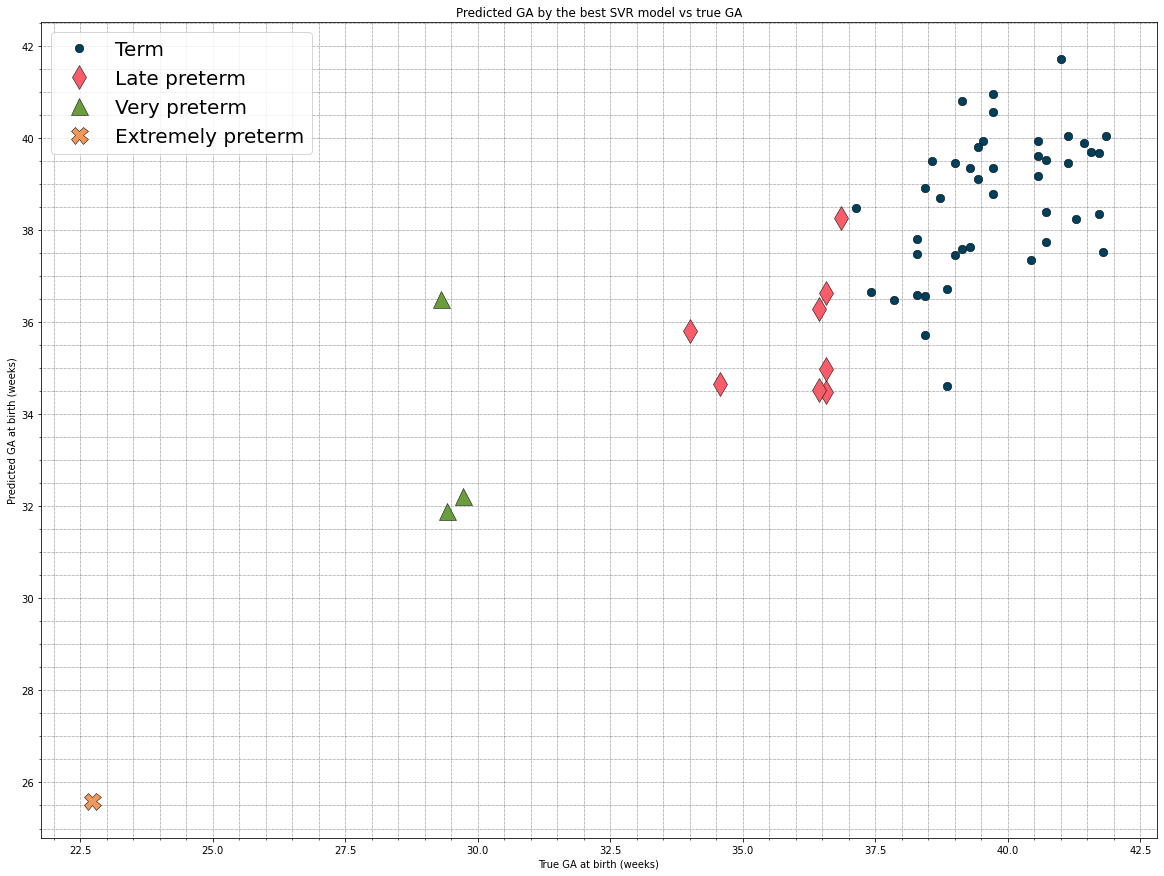

In [26]:
# Function to manually try the best outcomes, need to specify the hyperparameters
def try_best_from_comb(feature_labels):
    model = SVR(C = 100, gamma = 0.1, epsilon=0.1, kernel = 'sigmoid')
    data_to_use = get_processed_data()
    # Add weights column
    data_to_use['weights'] = pd.Series(get_weights_based_on_binary_category(), index = data_to_use.index)
    
    features_and_weight_labels = feature_labels + ['weights']
    
    features =  data_to_use[features_and_weight_labels]

    
    y = data_to_use['tag_gadel'].values.reshape(-1, 1)
    y = y.ravel()
    
    scaler = StandardScaler()
    weight_label_index = features.shape[1] - 1

    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size = 0.2, stratify=labels_4_cat, random_state = 1) 

    weights = X_train['weights']
    X_train = X_train[features_and_weight_labels[: weight_label_index]]
    X_test = X_test[features_and_weight_labels[: weight_label_index]]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train, sample_weight = weights)
    
    
    y_pred = model.predict(X_test)
 
    y_true = y_test
    r2 = r2_score(y_true, y_pred)
    print('R2 is: {}'.format(r2))
    mean_abs = mean_absolute_error(y_true, y_pred)
    print('MEAN ABS is: {}'.format(mean_abs))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE is: {}'.format(rmse))
    
    
    
    results_df = pd.DataFrame({'real_values':y_true, 'predicted_values':y_pred})

    svr_df = divide_to_categories(results_df, ['real_values', 'predicted_values'], ['real_values', 'predicted_values'])
    
    if (SHOW_VISUALISATIONS):
        plot_data(y_true, y_pred, svr_df['real_values_4_category'], BIRTH_CATEGORIES_4, 'True GA at birth (weeks)', 'Predicted GA at birth (weeks)', 'Predicted GA by the best SVR model vs true GA', False)

    return svr_df

    
res = try_best_from_comb(['plac_t2s_mean_z_score', 'tag_gu_hc_z_score', 'tag_gu_ac_z_score', 'tag_gu_fl_z_score', 'tag_gu_pi_right_z_score', 'tag_parity'])

<h1>8. Data exploration and visualisation functions</h1>

In [27]:
# Funtion to print out characteristics of a feature
def get_characteristics_of_feature(feature, feature_name, x_label, y_label, title = 'Histogram',display_graph = False):
    data = get_data()
    # Count how many instances do not have a value
    array = data[feature_name].values
    nr_of_NaN = np.count_nonzero(np.isnan(array))
    
    # Find percentage of missing values
    nr_of_rows = data[feature_name].size
    percentage_of_missing_vals = round((nr_of_NaN / nr_of_rows)*100, 2)
    print('These are the characteristics of feature {}:'.format(feature_name))
    print('{}% of values are missing.'.format(percentage_of_missing_vals))

    # Find the variance
    variance = np.nanvar(array) 
    print('Variance is: {}.'.format(round(variance, 3)))
    
    fig, ax = plt.subplots()
    
    if display_graph:
        # Plot histogram
        if (len(set(array)) == 2):
            nr_of_bins = 2
        else:
            nr_of_bins = 15

        counts, bins, patches = ax.hist(array, nr_of_bins, density=False, histtype='bar', facecolor='#003f5c', ec='black')

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xticks(bins)
        ax.set_xticklabels(ax.get_xticks(), rotation = 45)
        ax.set_title(title)

In [28]:
def count_instances_per_category(catecory_column_name):
    categories_data_new = get_data()[catecory_column_name]
    unique_new, counts_new = np.unique(categories_data_new, return_counts=True)
    return dict(zip(unique_new, counts_new)) 

In [29]:
def plot_histogram(values, x_label, y_label, title, x_step = 2, y_step = 2):
    minBin = int(min(values))
    maxBin = int(math.ceil(max(values))) + 2
    counts, bins, patches = plt.hist(values, np.arange(minBin, maxBin) - 0.5, density=False, histtype='bar', facecolor='#2f4b7c', ec='black')
    
    plt.xlabel(x_label, fontsize=18, labelpad=15)
    plt.ylabel(y_label, fontsize=18, labelpad=15)
    plt.title(title, fontsize=18)

    plt.xticks(np.arange(minBin, maxBin, x_step), rotation=90, fontsize = 14)
    plt.yticks(np.arange(0,max(counts) + 2, y_step), fontsize=14)
    
    save_fig(title, plt)

In [30]:
def first_digit(num):
    return int(str(num)[0])

In [31]:
def draw_pie_chart(list_of_nrs, labels):
    unique_new, counts_new = np.unique(list_of_nrs, return_counts=True)
    dict_of_study_participants = dict(zip(unique_new, counts_new))
    list_of_participant_per_study = list(dict_of_study_participants.values())

    study_labels = labels
    colors = COLORS
    fig1, ax1 = plt.subplots(figsize=(25,15))
    patches, texts, autotexts = ax1.pie(list_of_participant_per_study, colors = colors, startangle=180, autopct='%1.1f%%')
    plt.legend(study_labels, loc="best", prop={'size': 26})
    plt.axis('equal')

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_size(25)
        autotext.set_weight('bold')

    plt.show()


In [32]:
def generate_latex_table():
    # Descriptive statistics on the whole dataset before imputation
    original_data = get_data()
    all_col_names = original_data.columns
    nr_of_rows = original_data.shape[0]
    
    all_skews = original_data.skew(axis = 'index')
    all_means = original_data.mean(axis = 'index')
    all_medians = original_data.median(axis = 'index')
    all_std = original_data.std(axis = 'index')

    for i in range(0, len(all_skews)):
        array = original_data.iloc[:, i].values
        nr_of_NaN = np.count_nonzero(np.isnan(array))
        # Find percentage of missing values
        percentage_of_missing_vals = round((nr_of_NaN / nr_of_rows)*100, 2)

        print('$',all_col_names[i],'$','&', nr_of_NaN,'('+str(percentage_of_missing_vals)+'\%)','&', round(all_means[i],2), '&', round(all_medians[i],2), '&', round(all_std[i],2), '&', round(all_skews[i],2),"\\\\")
        print("\hline")

In [33]:
# Plot important features
def plot_important_features():
    data = get_data()
    features_to_plot = ['brain_t2s_vol', 'tag_bpd', 'tag_gu_hc']
    nr_of_features = len(features_to_plot)
    nr_of_cols = 1


    # Find how many rows are needed
    nr_of_rows = nr_of_features // nr_of_cols
    nr_of_rows += nr_of_features % nr_of_cols

    subplot_index = range(1, nr_of_features + 1)


    fig = plt.figure(1)
    fig.set_figheight(15)
    fig.set_figwidth(20)

    for i, tag in enumerate(features_to_plot):
        ax = fig.add_subplot(nr_of_rows, nr_of_cols, subplot_index[i])
        y_vals = data[tag]
        ax.plot(data['tag_ga'], y_vals, 'ob', color = '#2f4b7c')
        ax.set_xlabel('Gestational Age at Scan (weeks)')
        ax.set_ylabel(tag)

slope: 14.865862832719426 Term
intercept -274.4459971140441 Term
slope: 13.372209991966754 Preterm
intercept -234.327229516366 Preterm


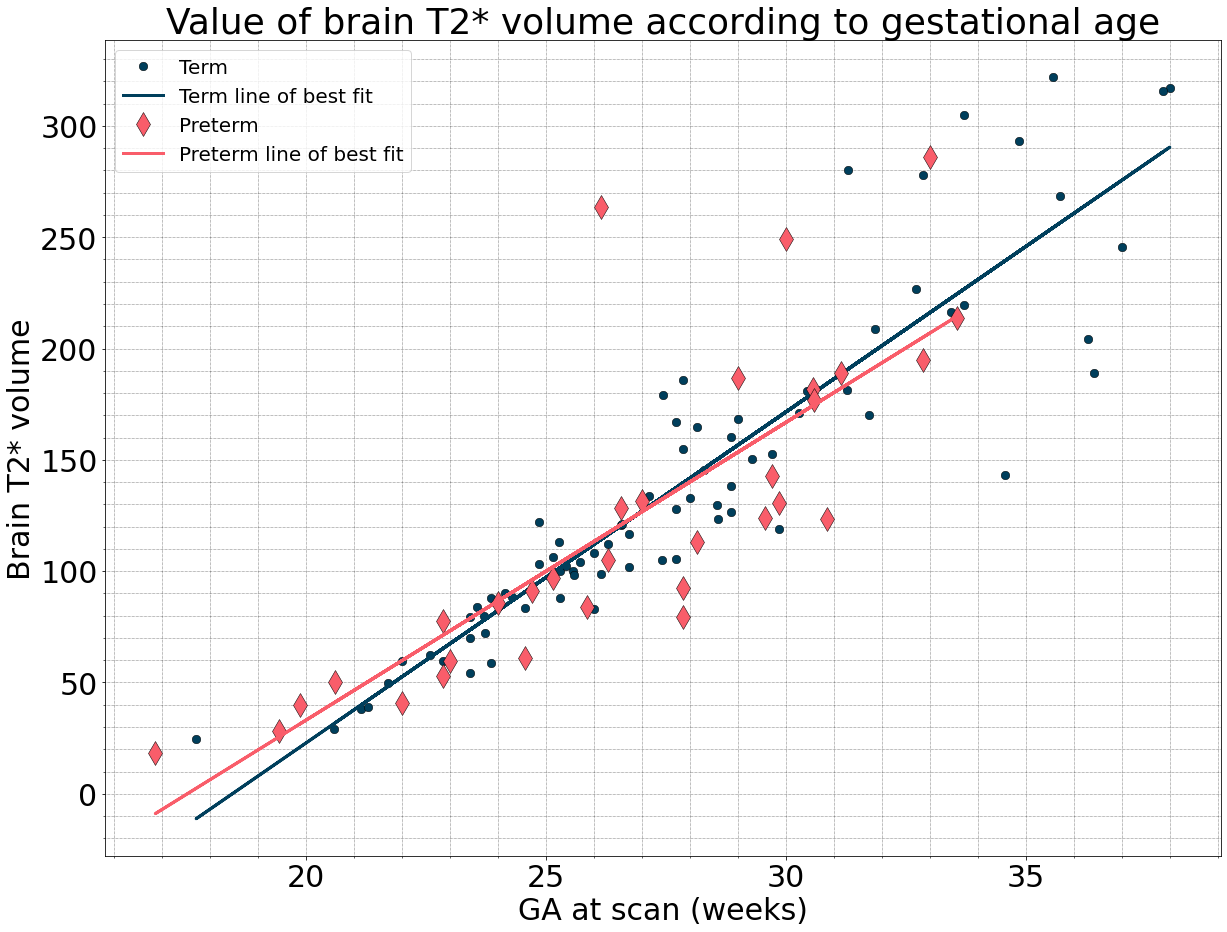

In [34]:
if (SHOW_VISUALISATIONS):
    plot_data(get_data()['tag_ga'], get_data()['brain_t2s_vol'], get_data()['ga_delivery_binary_category'], BIRTH_CATEGORIES_2, 'GA at scan (weeks)','Brain T2* volume','Value of brain T2* volume according to gestational age', True)
    

slope: 2.245152112560063 Term
intercept 8.001098014479961 Term
slope: 2.3534587225343597 Late preterm
intercept 1.3524628023172536 Late preterm
slope: 0.17125711971101537 Very preterm
intercept 62.54161861851762 Very preterm
slope: 1.3124999999999916 Extremely preterm
intercept 27.00781250000017 Extremely preterm


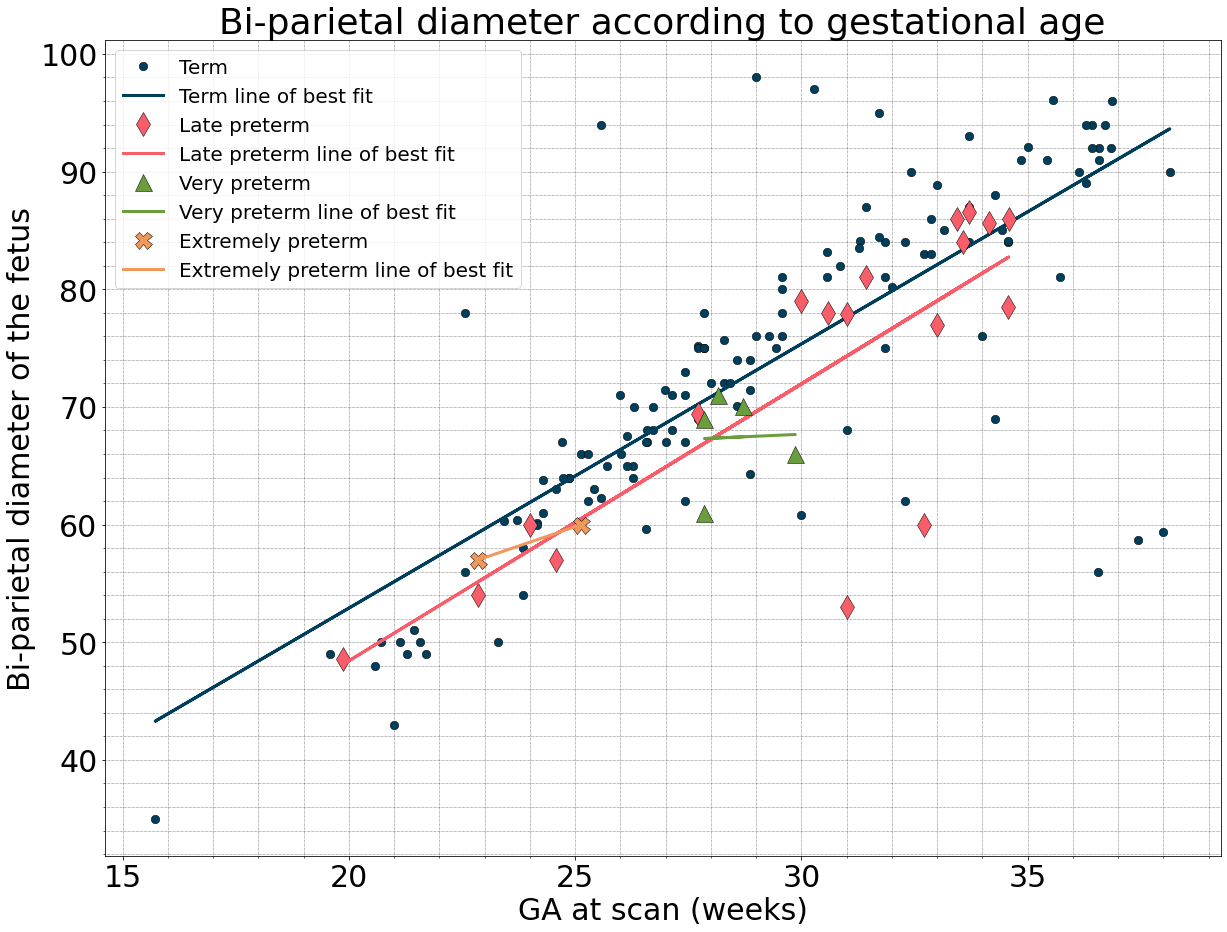

In [35]:
if (SHOW_VISUALISATIONS):
    plot_data(get_data()['tag_ga'], get_data()['tag_bpd'], get_data()['ga_delivery_4_category'], BIRTH_CATEGORIES_4, 'GA at scan (weeks)','Bi-parietal diameter of the fetus','Bi-parietal diameter according to gestational age', True)

slope: -2.8920344431020313 Term
intercept 142.07383553687055 Term
slope: -2.9264374747533934 Late preterm
intercept 126.96983821066979 Late preterm
slope: -4.5279542732537355 Very preterm
intercept 169.00978826944493 Very preterm
slope: -3.982184214814826 Extremely preterm
intercept 125.83107138822334 Extremely preterm


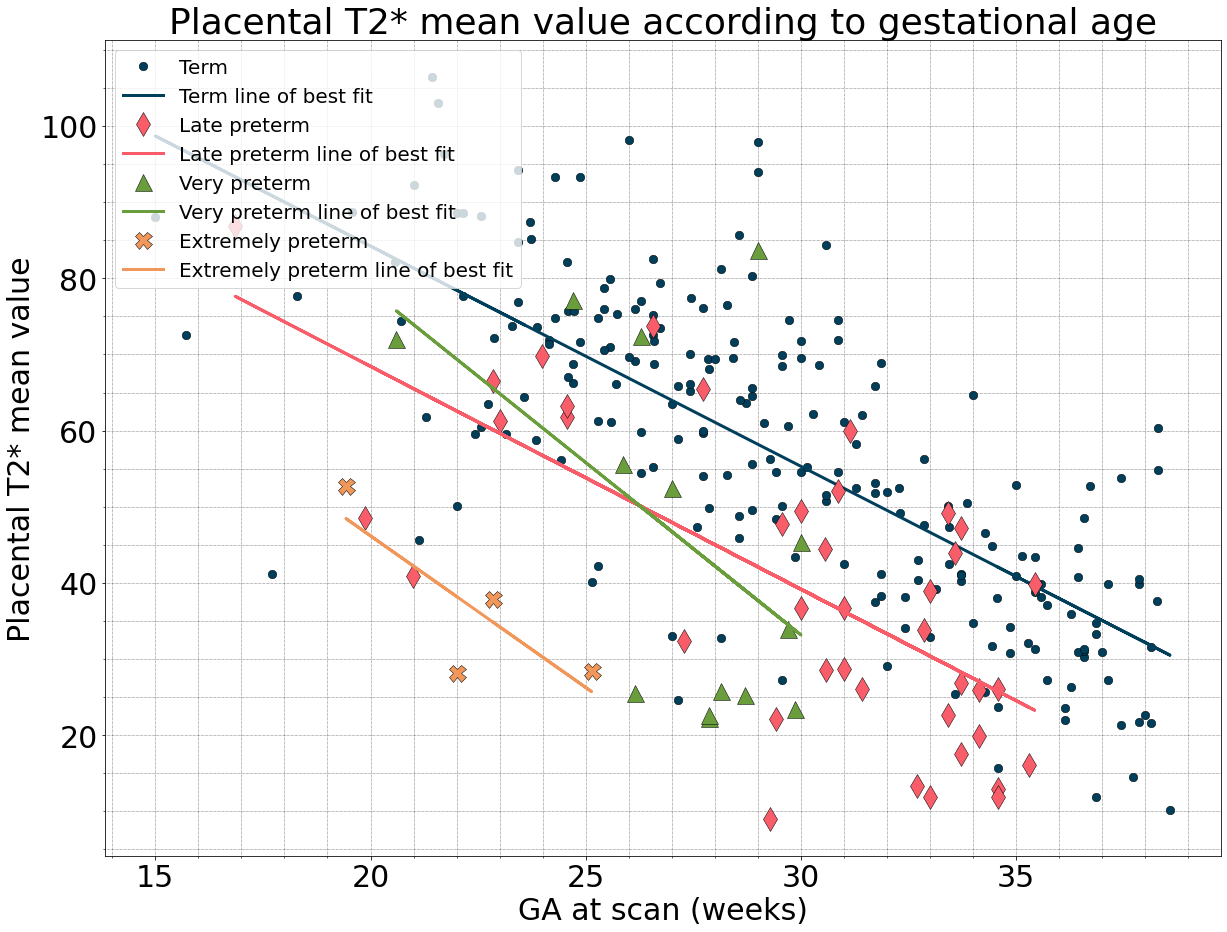

In [36]:
if (SHOW_VISUALISATIONS):
    plot_data(get_data()['tag_ga'], get_data()['plac_t2s_mean'], get_data()['ga_delivery_4_category'], BIRTH_CATEGORIES_4, 'GA at scan (weeks)','Placental T2* mean value','Placental T2* mean value according to gestational age', True)

slope: 0.03342517575066868 Term
intercept -1.2169920296350683 Term
slope: 0.034505439905384266 Late preterm
intercept -2.6438699173540816 Late preterm
slope: -0.10619325603078224 Very preterm
intercept 1.0564489341632768 Very preterm
slope: -0.05222741543072015 Extremely preterm
intercept -2.891277126231447 Extremely preterm


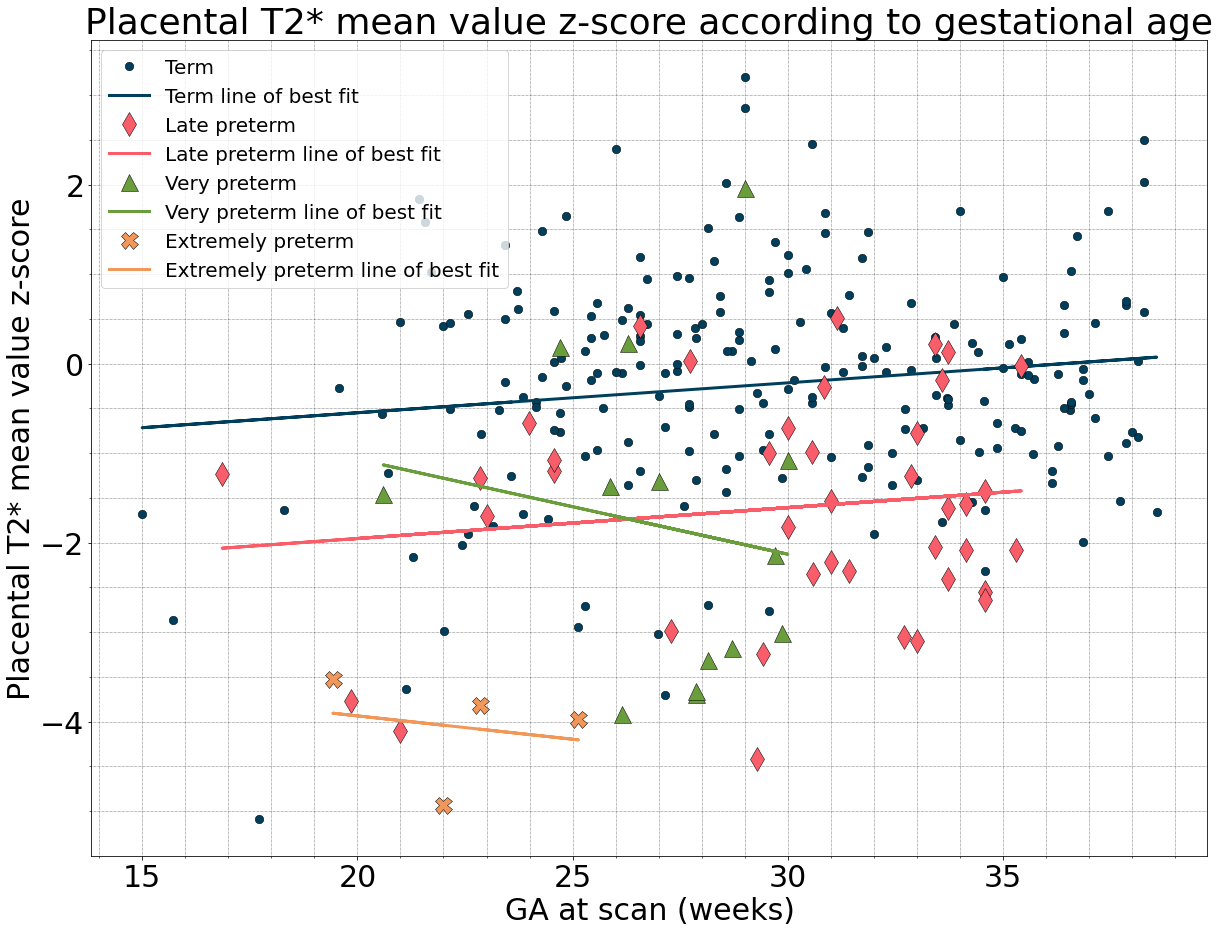

In [37]:
if (SHOW_VISUALISATIONS):
    feature_z_scores = get_data_with_z_scores()['plac_t2s_mean_z_score']
    plot_data(get_data()['tag_ga'], feature_z_scores, get_data()['ga_delivery_4_category'], BIRTH_CATEGORIES_4, 'GA at scan (weeks)', 'Placental T2* mean value z-score','Placental T2* mean value z-score according to gestational age', True)

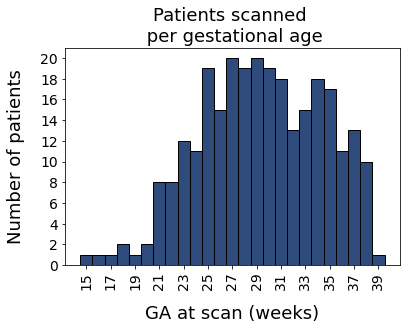

In [38]:
if (SHOW_VISUALISATIONS):
    plot_histogram(get_data()['tag_ga'], 'GA at scan (weeks)', 'Number of patients', 'Patients scanned \n per gestational age')

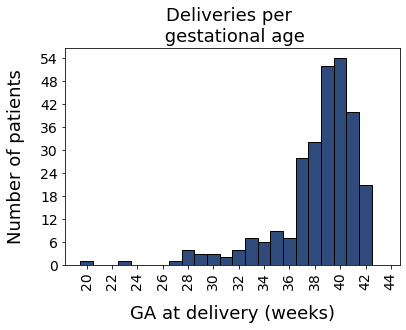

In [39]:
if (SHOW_VISUALISATIONS):
    plot_histogram(get_data()['tag_gadel'], 'GA at delivery (weeks)', 'Number of patients', 'Deliveries per \n gestational age', y_step = 6)

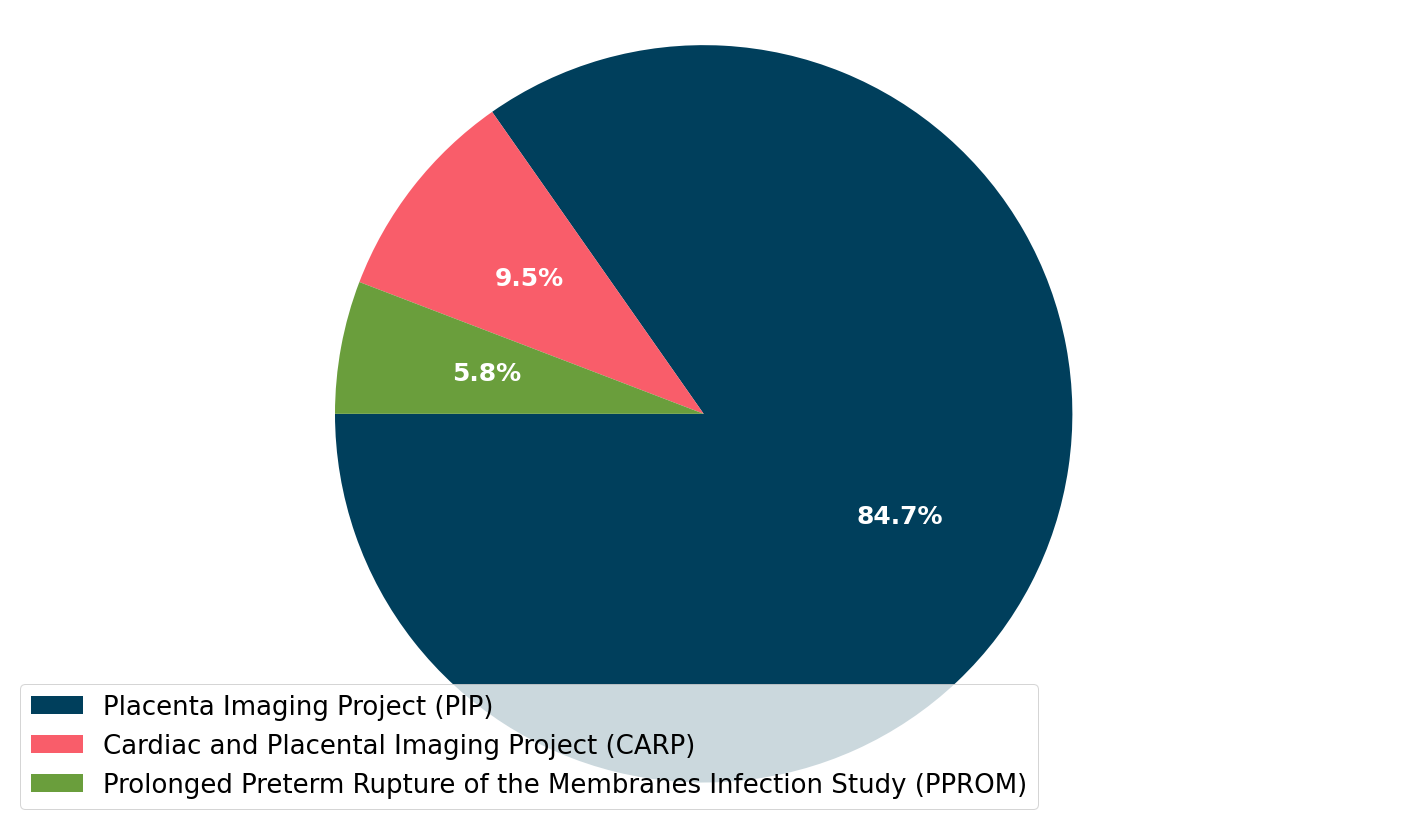

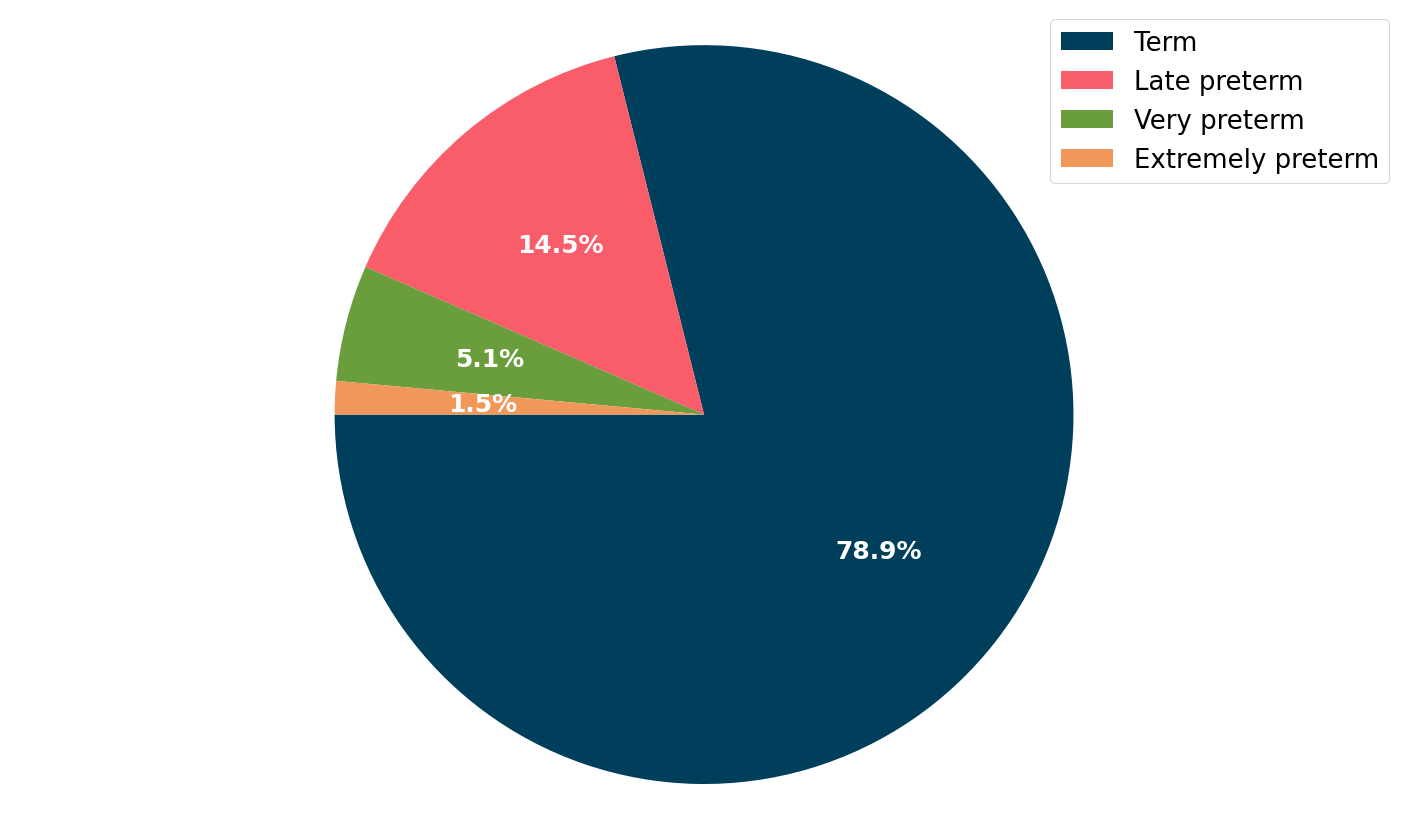

In [40]:
# Dataset statistics
patient_ids = get_data()['[208]']
list_of_study_nrs = [first_digit(i) for i in patient_ids]
labels_studies = ['Placenta Imaging Project (PIP)', 'Cardiac and Placental Imaging Project (CARP)', 'Prolonged Preterm Rupture of the Membranes Infection Study (PPROM)']

if SHOW_VISUALISATIONS:
    draw_pie_chart(list_of_study_nrs, labels_studies)
    
if (SHOW_VISUALISATIONS):
    draw_pie_chart(get_data()['ga_delivery_4_category'], BIRTH_CATEGORIES_4)

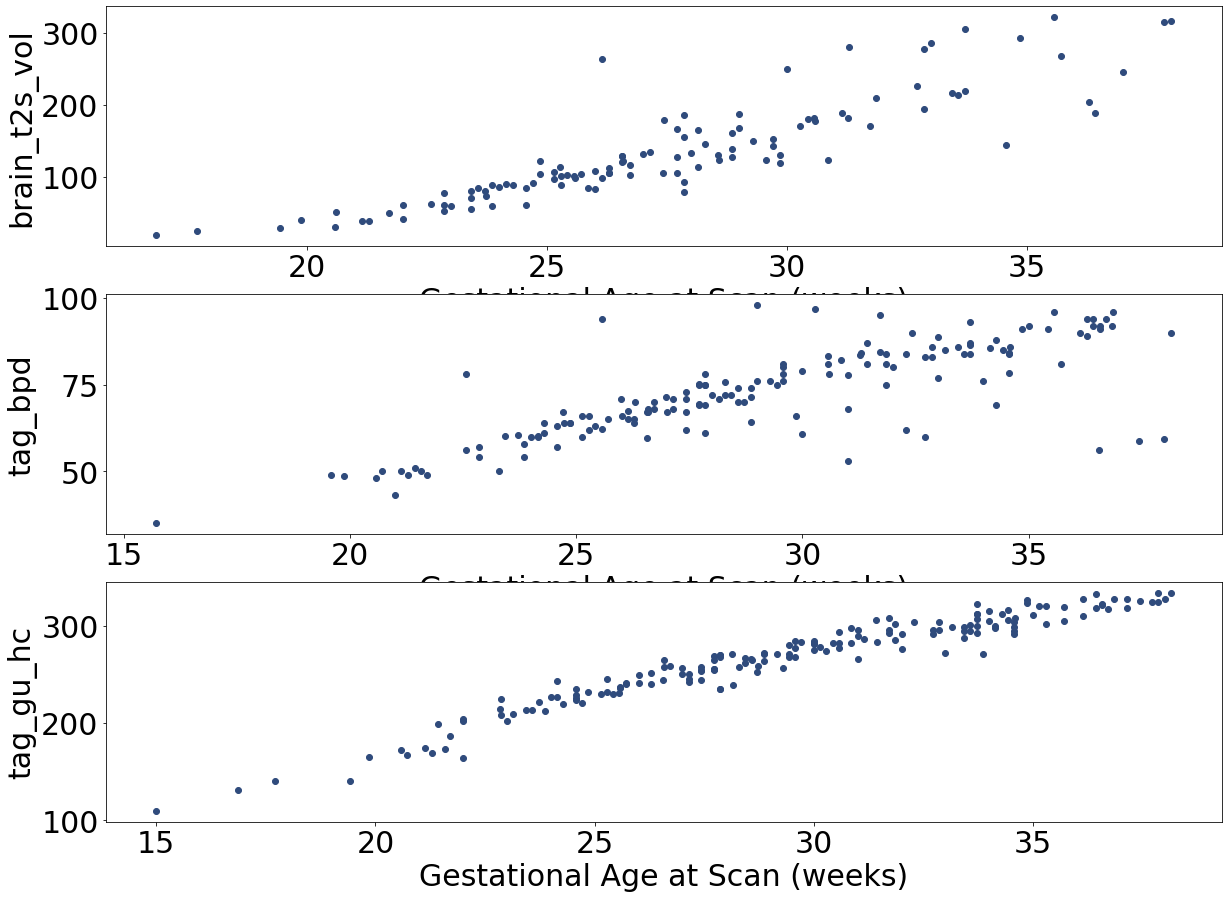

In [41]:
if (SHOW_VISUALISATIONS):
    plot_important_features()

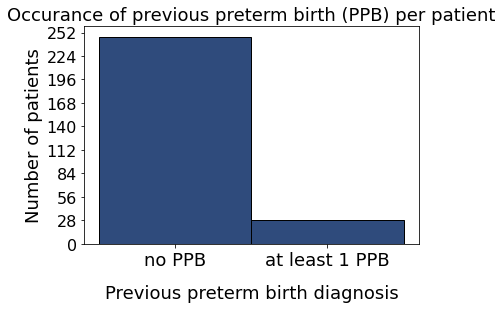

In [42]:
count_instances_per_category('tag_parity')
data = get_data()['tag_parity']

minBin = int(min(data))
maxBin = int(math.ceil(max(data))) + 2
counts, bins, patches = plt.hist(data, np.arange(minBin, maxBin) - 0.5, density=False, histtype='bar', facecolor='#2f4b7c', ec='black')

if (SHOW_VISUALISATIONS):
    plt.xticks(np.arange(minBin, maxBin - 1, 1.0), ['no PPB','at least 1 PPB'], fontsize=18)
    plt.yticks(np.arange(0, 253, 28), fontsize=16)
    plt.xlabel('Previous preterm birth diagnosis', fontsize=18, labelpad=15)
    plt.ylabel('Number of patients', fontsize=18)
    plt.title('Occurance of previous preterm birth (PPB) per patient', fontsize=18)

    fileName = 'parity_graph'
    plt.savefig('./Images/{}' + '.jpg'.format(fileName), bbox_inches='tight', dpi=250)



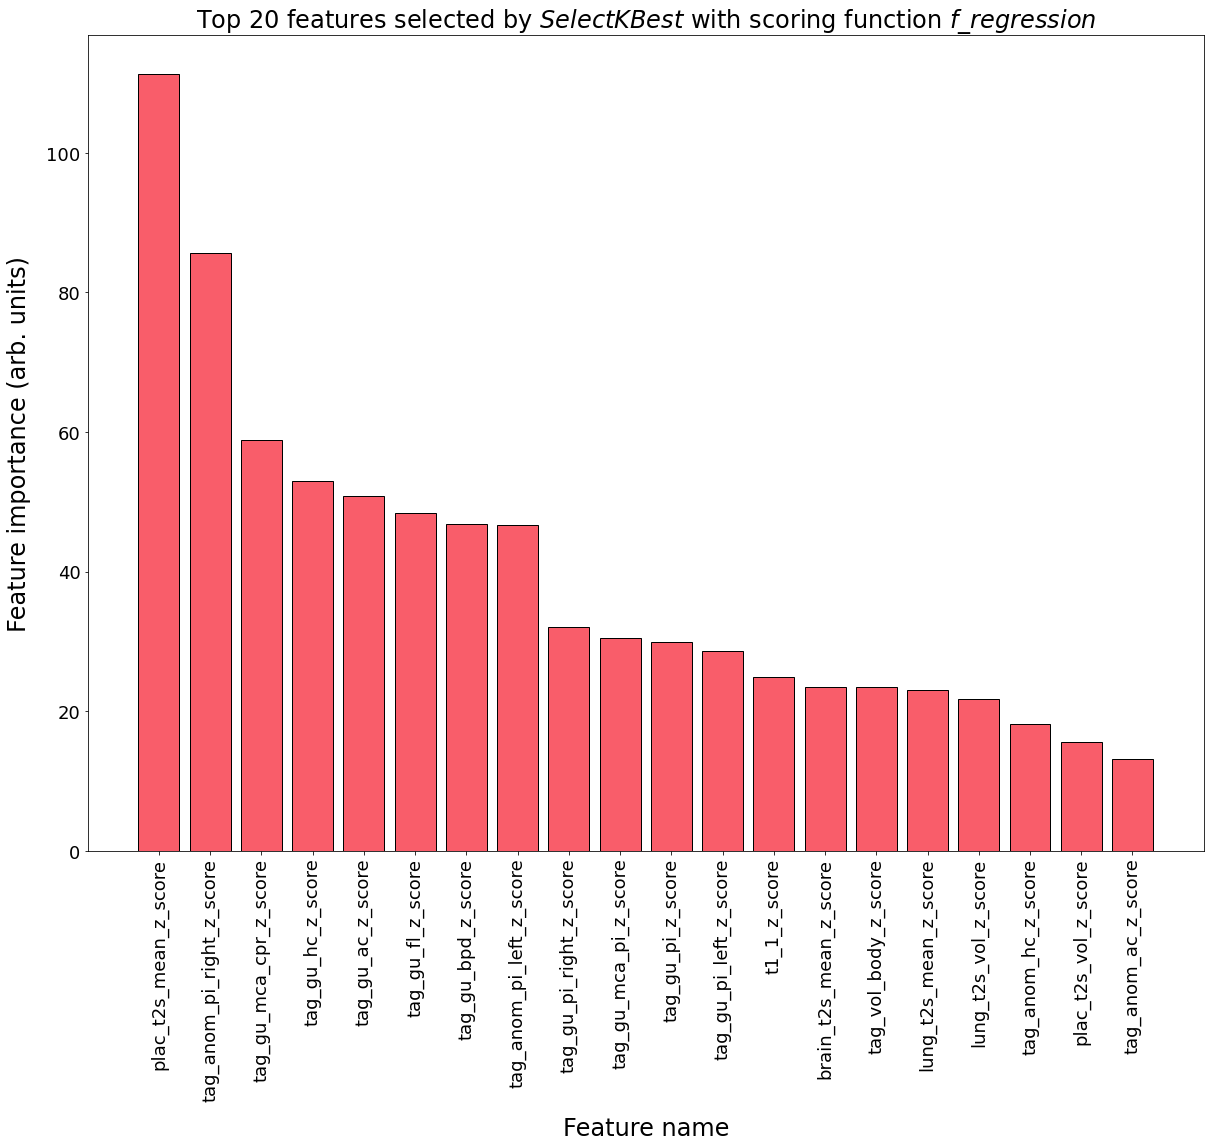

In [43]:
sorted_dict_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

sorted_list_feature_importance_keys = list(sorted_dict_feature_importances.keys())
sorted_list_feature_importance_values = list(sorted_dict_feature_importances.values())

if SHOW_VISUALISATIONS:
    plt.figure(figsize = (20, 15))
    plt.bar(sorted_list_feature_importance_keys[0:20],sorted_list_feature_importance_values[0:20], color = '#f95d6a', edgecolor ='black')
    plt.xlabel('Feature name', fontsize=24, labelpad=15)
    plt.ylabel('Feature importance (arb. units)', fontsize=24, labelpad=15)
    plt.title('Top 20 features selected by $\it{SelectKBest}$ with scoring function $\it{f\_regression}$', fontsize=24)

    plt.xticks(rotation=90, fontsize = 18)
    plt.yticks(fontsize=18)

Statistics before: mean - 0.8696484374999999, std - 0.268691987629532, min - 0.39, max - 1.76
Statistics after: mean - 0.898279407701933, std - 0.2026179737940482, min - 0.39, max - 1.76


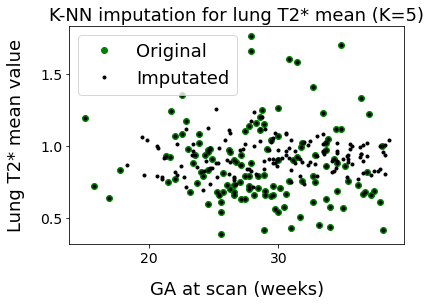

In [44]:
data_imp_after_z_scores = perform_imputation(get_data_with_z_scores())

if (SHOW_VISUALISATIONS): 
    tag_y = 'tag_gu_pi_right'
    feature_array = get_data()[tag_y]
    print('Statistics before: mean - {}, std - {}, min - {}, max - {}'.format(mean(feature_array), std(feature_array), np.nanmin(feature_array), np.nanmax(feature_array)))
    feature_array_imp =  data_imp_after_z_scores[tag_y]
    print('Statistics after: mean - {}, std - {}, min - {}, max - {}'.format(mean(feature_array_imp), std(feature_array_imp), min(feature_array_imp), max(feature_array_imp)))

    plt.plot(get_data()['tag_ga'], feature_array, 'og', data_imp_after_z_scores['tag_ga'], feature_array_imp, '.k')
    plt.title('K-NN imputation for lung T2* mean (K=5)',  fontsize=18)
    plt.xlabel('GA at scan (weeks)',  fontsize=18, labelpad=15)
    plt.ylabel('Lung T2* mean value',  fontsize=18, labelpad=15)
    plt.legend(['Original', 'Imputated'],  fontsize=18)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    save_fig(tag_y, plt)
    plt.show()


16
Accuracy: 0.818
Recall: [0.8372093  0.875      0.33333333 1.        ]
Precision: [0.97297297 0.4375     1.         1.        ]


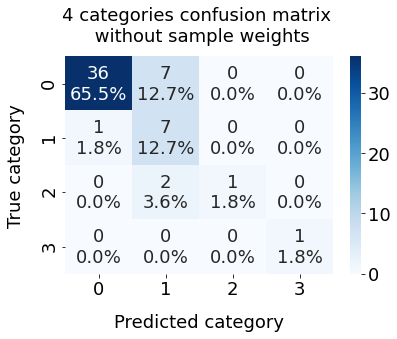

In [45]:
y_true = res['real_values_4_category']
y_pred = res['predicted_values_4_category']
cm = confusion_matrix(y_true, y_pred)

group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
#print(group_counts)
group_percentages = ['{0:.1%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
print(len(group_percentages))
labels = [f'{v2}\n{v3}'for v2, v3 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(4,4)
ax = plt.axes()
sns.heatmap(cm, annot=labels, fmt='', ax = ax, cmap='Blues', annot_kws={"size": 18})
ax.set_title('4 categories confusion matrix \n without sample weights', fontsize = 18, pad=15)
ax.set_xlabel('Predicted category', fontsize = 18, labelpad=15)
ax.set_ylabel('True category', fontsize = 18, labelpad=15)
ax.tick_params(axis = 'both', labelsize = 18)
print('Accuracy:', round(accuracy_score(y_true, y_pred), 3))
print('Recall:', recall_score(y_true, y_pred, average=None))
print('Precision:', precision_score(y_true, y_pred, average=None))
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
save_fig('4 cat confusion matrix without weights best model new lalla', plt)

Accuracy: 0.855
Recall: [0.8372093  0.91666667]
Precision: [0.97297297 0.61111111]


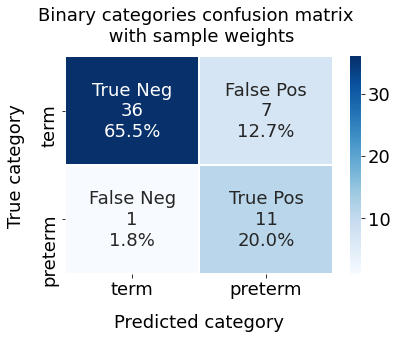

In [46]:
y_true_binary = res['real_values_binary_category']
y_pred_binary = res['predicted_values_binary_category']
cm_bin = confusion_matrix(y_true_binary, y_pred_binary)
group_names_bin = ['True Neg','False Pos','False Neg','True Pos']
group_counts_bin = ['{0:0.0f}'.format(value) for value in
                cm_bin.flatten()]
group_percentages_bin = ['{0:.1%}'.format(value) for value in
                     cm_bin.flatten()/np.sum(cm_bin)]
labels_bin = [f'{v1}\n{v2}\n{v3}'for v1, v2, v3 in
          zip(group_names_bin,group_counts_bin,group_percentages_bin)]
labels_bin = np.asarray(labels_bin).reshape(2,2)

ax = plt.axes()
sns.heatmap(cm_bin, annot=labels_bin, fmt='', cmap='Blues', ax = ax, linewidths=.5, annot_kws={"size": 18})
ax.set_title('Binary categories confusion matrix \n with sample weights', fontsize = 18, pad=15)
ax.set_xlabel('Predicted category', fontsize = 18, labelpad=15)
ax.set_ylabel('True category', fontsize = 18, labelpad=15)

ax.tick_params(axis = 'both', labelsize = 18)
ax.set_xticks((0.5, 1.5))
ax.set_yticks((0.5, 1.5))
ax.set_xticklabels(labels = ['term', 'preterm'])
ax.set_yticklabels(labels = ['term', 'preterm'])

print('Accuracy:', round(accuracy_score(y_true_binary, y_pred_binary), 3))
print('Recall:', recall_score(y_true_binary, y_pred_binary, average=None))
print('Precision:', precision_score(y_true_binary, y_pred_binary, average=None))
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=18)
save_fig('binary cat confusion matrix with weights best model new lalal', plt)